# Deep Learning
## Omar Farooq
# Masked RCNN



## Application/Dataset: ID classification and labeling
#### 1 Masked RCNN model was made for ID classification as being either of UK, USA, pakistan, or singapore
#### 4 Masked RCNN models were then made to detect the labels in each of the class

In [2]:
!git clone https://github.com/matterport/Mask_RCNN.git

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 125.23 MiB | 27.85 MiB/s, done.
Resolving deltas: 100% (562/562), done.


In [3]:
%cd Mask_RCNN
!pip install imutils
!python setup.py install

/kaggle/working/Mask_RCNN
  Created wheel for imutils: filename=imutils-0.5.4-cp36-none-any.whl size=25860 sha256=db8664d7f2b5d92fe81f57ba347a78c52225562716e1c5a7fe45f2bca5eea11d
  Stored in directory: /root/.cache/pip/wheels/db/23/45/fc7424906880ffa9577a2a428b961f2b79e0e21d9f71e7e6bc
Successfully built imutils
running install
running bdist_egg
running egg_info
creating mask_rcnn.egg-info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/mrcnn
copying mrcnn/utils.py -> build/lib/mrcnn
copying mrcnn/visualize.py -> build/lib/mrcnn
copying mrcnn/__init__.py -> build/lib/mrcnn
copying m

In [4]:
from mrcnn.config import Config
from mrcnn import model as modellib
from mrcnn import visualize
import mrcnn
from mrcnn.utils import Dataset
from mrcnn.model import MaskRCNN
from mrcnn.utils import compute_iou
import numpy as np
from numpy import zeros
from numpy import asarray
import colorsys
import argparse
import imutils
import random
import cv2
import os
import time
from matplotlib import pyplot
from matplotlib.patches import Rectangle
from keras.models import load_model
%matplotlib inline
from os import listdir
from xml.etree import ElementTree
import pandas as pd
import time
import numpy
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [5]:
class c_Config(Config):
    # give the configuration a recognizable name
    NAME = "c_MaskRCNN_config"
 
    # set the number of GPUs to use along with the number of images
    # per GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
 
    # number of classes (we would normally add +1 for the background)
     # kangaroo + BG
    NUM_CLASSES = 4+1
   
    # Number of training steps per epoch
    STEPS_PER_EPOCH = 131
    
    # Learning rate
    LEARNING_RATE=0.001
    
    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.75
    
    # setting Max ground truth instances
    MAX_GT_INSTANCES=10

In [6]:
config_c = c_Config()
config_c.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.75
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                17
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE        

In [7]:
import random


class IDcDataset(Dataset):
    # load the dataset definitions
    def load_dataset(self, dataset_dir, is_train=True):
        
        # Add classes. We have only one class to add.
        self.add_class("dataset", 1, "us")
        self.add_class("dataset", 2, "uk")
        self.add_class("dataset", 3, "pk")
        self.add_class("dataset", 4, "sp")
        
        # define data locations for images and annotations
        images_dir = dataset_dir + '/images/'
        annotations_dir = dataset_dir + '/c_labels/'
        files = [x[:-4]+'.jpg' for x in list(listdir(annotations_dir))]
        random.shuffle(files)
        size = len(files)
        # Iterate through all files in the folder to 
        #add class, images and annotaions
        for i in range(size):
            
            # extract image id
            image_id = files[i][:-4]
            #1 - 169 is pakistani dataset
            #171 -340 UK dataset
            #341 - 495 Pakistan

            # skip bad images
            #if image_id in ['00090']:
             #   continue
            # use only int files
              
            # skip test images if we are building the train set

            # train ratio: 0.8 
            #TRAIN Data
            # when training skip test dataset
            if is_train and i > int(0.8*size):
                continue
            
            #when testing, skip train dataset
            if not is_train and i > int(1000*size):
                continue
            

            # setting image file
            img_path = images_dir + files[i]
            
            # setting annotations file
            ann_path = annotations_dir + image_id + '.xml'
            
            # adding images and annotations to dataset
            self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)
# extract bounding boxes from an annotation file
    def extract_boxes(self, filename):
        
        # load and parse the file
        tree = ElementTree.parse(filename)
        # get the root of the document
        root = tree.getroot()
        # extract each bounding box
        boxes = list()
        #''
        for box in root.findall('.//object'):
            xmin = int(box.find('.//bndbox/xmin').text)
            ymin = int(box.find('.//bndbox/ymin').text)
            xmax = int(box.find('.//bndbox/xmax').text)
            ymax = int(box.find('.//bndbox/ymax').text)
            lab = box.find('name').text
            coors = [xmin, ymin, xmax, ymax, lab]
            boxes.append(coors)
        
        # extract image dimensions
        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        return boxes, width, height
        # load the masks for an image
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
     """
    def load_mask(self, image_id):
        # get details of image
        info = self.image_info[image_id]
        
        # define anntation  file location
        path = info['annotation']
        
        # load XML
        boxes, w, h = self.extract_boxes(path)
       
        # create one array for all masks, each on a different channel
        masks = zeros([h, w, len(boxes)], dtype='uint8')
        
        # create masks
        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            label = box[4]
            masks[row_s:row_e, col_s:col_e, i] = 1
            class_ids.append(self.class_names.index(label))

        #print(image_id, class_ids)
        return masks, asarray(class_ids, dtype='int32')
# load an image reference
     #Return the path of the image
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        print(info)
        return info['path']

In [8]:
# prepare train set
# train_set_c =IDcDataset()
# train_set_c.load_dataset('../../input/idnation', is_train=True)
# train_set_c.prepare()
# print('Train: %d' % len(train_set_c.image_ids))
# prepare test/val set
test_set_c = IDcDataset()
test_set_c.load_dataset('../../input/idnation', is_train=False)
test_set_c.prepare()
print('Test: %d' % len(test_set_c.image_ids))

Test: 1003


In [ ]:
print("Loading Mask R-CNN model...")
model_c = modellib.MaskRCNN(mode="training", config=config_c, model_dir='./')

In [ ]:
#load the weights for COCO
model_c.load_weights('../../input/coco-weights-for-maskedrcnn-matterport/mask_rcnn_coco.h5', 
                   by_name=True, 
                   exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])

In [ ]:
import warnings
warnings.filterwarnings('ignore')
## train heads with higher lr to speedup the learning
model_c.train(train_set_c, test_set_c, learning_rate=2*config_c.LEARNING_RATE, epochs=30, layers='heads')


In [ ]:
history_c = model_c.keras_model.history.history

In [ ]:
hist_df.head(1)

In [ ]:
import pandas as pd
import time

hist_df = pd.DataFrame(history_c) 
# or save to csv: 
hist_csv_file = 'history_c.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

t = str(time.time())
model_path_c = 'mask_rcnn_c_'  + '.' + t + '.h5'
model_c.keras_model.save_weights(model_path)
from IPython.display import FileLink
FileLink('mask_rcnn_c_'  + '.' + t + '.h5')

In [ ]:
import numpy
import matplotlib.pyplot as plt
# plot the training loss and accuracy
plt.rcParams["figure.figsize"] = (12,8)
N = numpy.arange(0, 30)
plt.style.use("ggplot")
plt.figure()
for i in hist_df.columns:
    plt.plot(N, history_c[i], label=i)

plt.title("Training Loss and Accuracy (Masked RCNN)")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

In [ ]:
print("Loading Mask R-CNN model...")
model_c = modellib.MaskRCNN(mode="inference", config=config_c, model_dir='./')
#load the weights for COCO
model_c.load_weights('../../input/id-models/mask_rcnn_c_.1623084794.8989007.h5', by_name=True)


In [12]:
#Testing country model.
#testing for IOUs per model
import glob

for key in ['c']:
    weight_path = glob.glob('../../input/id-models/mask_rcnn_c.*.h5')
#     files = [x[:-4] for x in list(listdir('../../input/idnation/'+key+'_labels'))]
    res = {x:dict(zip(test_set_c.class_names[1:], np.empty((7,)))) for x in test_set_c.image_ids}

    print("Loading Mask R-CNN model...")
    model_c = modellib.MaskRCNN(mode="inference", config=config_c, model_dir='./')
    #load the weights for COCO
    model_c.load_weights('../../input/id-models/mask_rcnn_c_.1623084794.8989007.h5', by_name=True)

#     print("Loading Mask R-CNN model...")
#     datasets[key]['model'] = modellib.MaskRCNN(mode="inference", config=config, model_dir='./')
#     #load the weights for COCO
#     datasets[key]['model'].load_weights(weight_path[0], by_name=True)

    for i in range(len(test_set_c.image_ids)):
        image_id = i
        image, image_meta, gt_class_id, gt_bbox, gt_mask =    modellib.load_image_gt(test_set_c, config_c, image_id, use_mini_mask=False)
        info = test_set_c.image_info[image_id]
        
        # Run object detection
        results = model_c.detect([image], verbose=0)
        # Display results
        #print('results', results)
        r = results[0]

        for x in range(len(gt_class_id)):
            a = np.concatenate([np.where(r['class_ids']==gt_class_id[x])[0]])
            # print(a)
            if len(a)>0:
                pmasks = np.stack([r['masks'][:,:,i] for i in a], axis=2)
    #           print(gt_mask.shape)
                iou = c_iou(pmasks, gt_mask[:,:,x])
                print('IOU ', info['id'], test_set_c.class_names[gt_class_id[x]], iou)
                res[test_set_c.image_ids[i]][test_set_c.class_names[gt_class_id[x]]]= iou
        
#         visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
#                              test_set_c.class_names, r['scores'], 
#                                 title="Predictions")
#         print("image ID: {}.{} ({}) {} ".format(info["source"], info["id"], image_id, 
# test_set_c.image_reference(image_id)))
        
    
    df = pd.DataFrame(res).T
    df.to_csv("IOU_table_"+key+".csv")
    df.head()

Loading Mask R-CNN model...
IOU  spej-ic820 sp 0.8337973382595912
IOU  spDogIC95 sp 0.9381238581905795
IOU  apk00161032 pk 0.7941879738825611
IOU  spimages (2)45 sp 0.8398031265788173
IOU  apkimages332 pk 0.8028630251560188
IOU  apk00167632 pk 0.8636734986383833
IOU  us522de527c8fd0c20bede6b1a3c8f5d63312 us 0.8699206530239834
IOU  spimages (2)420 sp 0.9077784832397534
IOU  apkEVqnEDVXQAYU2kb pk 0.827480623568106
IOU  apk00386332 pk 0.8840021585557299
IOU  apkEgR0BxXVAAESPSG232 pk 0.9527109755001876
IOU  usA32630 us 0.9410294602781082
IOU  apk00347132 pk 0.7120373999783737
IOU  apkEgR6CvyVoAA5HEM032 pk 0.7741047224996433
IOU  spfake-Singapore-id-card-300x200325 sp 0.8724593334813077
IOU  apkEVqnFQrXYAAEUbC532 pk 0.943480685080217
IOU  apk00167032 pk 0.7920623206232063
IOU  apkimages532 pk 0.9030763615601161
IOU  apk00167832 pk 0.8891125653572866
IOU  apk002 pk 0.9475341612380465
IOU  apk00166432 pk 0.928764980590831
IOU  apkb40d44d513e237b4205aba8839d3d275832 pk 0.6710542768942206
IOU  

AttributeError: 'NoneType' object has no attribute 'head'

In [14]:
df = pd.DataFrame(res).T
df.to_csv("IOU_table_"+key+".csv")
df.head()

,us,uk,pk,sp
0,0.0,4.940656e-324,9.881313e-324,8.337973e-01
1,0.0,4.940656e-324,9.881313e-324,1.482197e-323
2,0.0,4.940656e-324,9.881313e-324,9.381239e-01
3,0.0,4.940656e-324,7.941880e-01,1.482197e-323
4,0.0,4.940656e-324,9.881313e-324,8.398031e-01


In [ ]:
pd.DataFrame(res).T.describe()

In [ ]:
for i in range(201):
    image_id = i
    image, image_meta, gt_class_id, gt_bbox, gt_mask =    modellib.load_image_gt(test_set_c, config_c, image_id, use_mini_mask=False)
    info = test_set_c.image_info[image_id]
    print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                           test_set_c.image_reference(image_id)))
    # Run object detection
    results = model_c.detect([image], verbose=0)
    # Display results
    #print('results', results)
    r = results[0]
    visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                                test_set_c.class_names, r['scores'], 
                                title="Predictions")

In [ ]:
print(test_set_c.class_names[r['class_ids'][0]])

In [9]:
def RepresentsInt(s):
    try: 
        int(s)
        return True
    except ValueError:
        return False

In [10]:
class MRCNNconfig(Config):
    # give the configuration a recognizable name
    NAME = "MaskRCNN_config"
 
    # set the number of GPUs to use along with the number of images
    # per GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
 
    # number of classes (we would normally add +1 for the background)
     # kangaroo + BG
    NUM_CLASSES = 6+1
   
    # Number of training steps per epoch
    STEPS_PER_EPOCH = 131
    
    # Learning rate
    LEARNING_RATE=0.001
    
    USE_MINI_MASK = False
    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.85
    
    # setting Max ground truth instances
    MAX_GT_INSTANCES=10

In [11]:
class IDDataset(Dataset):
    
    # load the dataset definitions
    def load_dataset(self, dataset_dir, c, is_train=True):
        self.country = c
        
        # Add classes. We have only one class to add.
        self.add_class("dataset", 1, "Fname")
        self.add_class("dataset", 2, "Lname")
        self.add_class("dataset", 3, "DOB")
        self.add_class("dataset", 4, "gender")
        self.add_class("dataset", 5, "IDnumber")
        self.add_class("dataset", 6, "nationality")
        
        
        # define data locations for images and annotations
        images_dir = dataset_dir + '/images/'
        annotations_dir = dataset_dir + '/'+self.country+'_labels/'
        
        files = [x[:-4]+'.jpg' for x in list(listdir(annotations_dir))]
        random.shuffle(files)
        size = len(files)
        # Iterate through all files in the folder to 
        #add class, images and annotaions
        for i in range(size):
            
            # extract image id
            image_id = files[i][:-4]
            #1 - 169 is pakistani dataset
            #171 -340 UK dataset
            #341 - 495 Pakistan

            # skip bad images
            #if image_id in ['00090']:
             #   continue
            # use only int files
              
            # skip test images if we are building the train set

            # train ratio: 0.8 
            #TRAIN Data
            # when training skip test dataset
            if is_train and i > int(0.8*size):
                continue
            
            #when testing, skip train dataset
            if not is_train and i > int(1000*size):
                continue
            

            # setting image file
            img_path = images_dir + files[i]
            
            # setting annotations file
            ann_path = annotations_dir + image_id + '.xml'
            
            # adding images and annotations to dataset
            self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)
# extract bounding boxes from an annotation file
    def extract_boxes(self, filename):
        
        # load and parse the file
        tree = ElementTree.parse(filename)
        # get the root of the document
        root = tree.getroot()
        # extract each bounding box
        boxes = list()
        #''
        for box in root.findall('.//object'):
            lab = box.find('name').text
            
            xmin = int(box.find('.//bndbox/xmin').text)
            ymin = int(box.find('.//bndbox/ymin').text)
            xmax = int(box.find('.//bndbox/xmax').text)
            ymax = int(box.find('.//bndbox/ymax').text)
            
            coors = [xmin, ymin, xmax, ymax, lab]
            boxes.append(coors)
        
        # extract image dimensions
        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        return boxes, width, height
        # load the masks for an image
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
     """
    def load_mask(self, image_id):
        # get details of image
        info = self.image_info[image_id]
        
        # define anntation  file location
        path = info['annotation']
        
        # load XML
        boxes, w, h = self.extract_boxes(path)
       
        # create one array for all masks, each on a different channel
        masks = zeros([h, w, len(boxes)], dtype='uint8')
        
        # create masks
        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            label = box[4]
            masks[row_s:row_e, col_s:col_e, i] = 1
            class_ids.append(self.class_names.index(label))

        #print(image_id, class_ids)
        return masks, asarray(class_ids, dtype='int32')
# load an image reference
     #Return the path of the image
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        print(info)
        return info['path']

In [12]:
datasets = {'pk': {},
           'sp': {},
           'uk': {},
           'us': {}}
for key in datasets.keys():
    print('preparing dataset of country', key)
#     # prepare train set
#     datasets[key]['train_set'] =IDDataset()
#     datasets[key]['train_set'].load_dataset('../../input/idnation', key, is_train=True)
#     datasets[key]['train_set'].prepare()
#     print('Train: %d' % len(datasets[key]['train_set'].image_ids))
    # prepare test/val set
    datasets[key]['test_set'] = IDDataset()
    datasets[key]['test_set'].load_dataset('../../input/idnation', key, is_train=False)
    datasets[key]['test_set'].prepare()
    print('Test: %d' % len(datasets[key]['test_set'].image_ids))
    

preparing dataset of country pk
Test: 352
preparing dataset of country sp
Test: 305
preparing dataset of country uk
Test: 305
preparing dataset of country us
Test: 306


In [13]:
config = MRCNNconfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.85
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                19
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE        

In [ ]:

print("Loading Mask R-CNN model...")
datasets['pk']['model'] = modellib.MaskRCNN(mode="training", config=config, model_dir='./')

In [ ]:
#load the weights for COCO
datasets['pk']['model'].load_weights('../../input/coco-weights-for-maskedrcnn-matterport/mask_rcnn_coco.h5', 
                   by_name=True, 
                   exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
## train heads with higher lr to speedup the learning
datasets['pk']['model'].train(datasets['pk']['train_set'], datasets['pk']['test_set'], learning_rate=2*config.LEARNING_RATE, epochs=30, layers='heads')
datasets['pk']['history'] = datasets['pk']['model'].keras_model.history.history

In [1]:
import numpy
import matplotlib.pyplot as plt
import pandas as pd

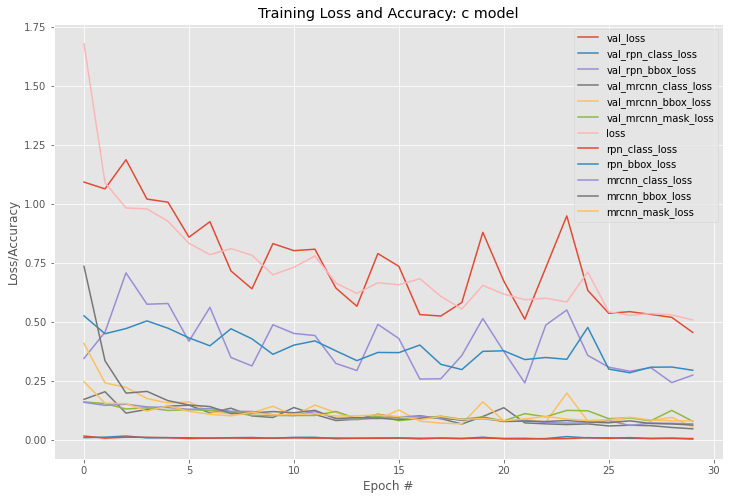

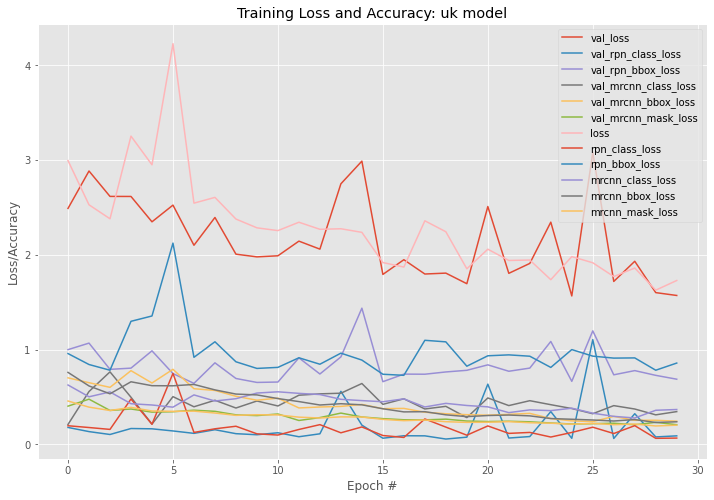

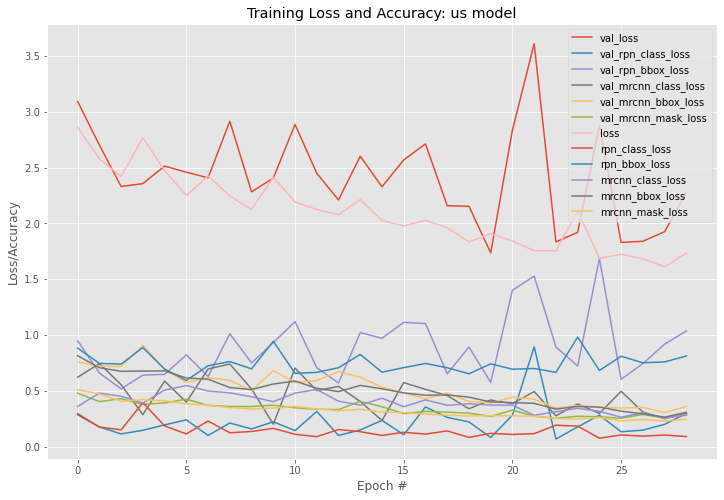

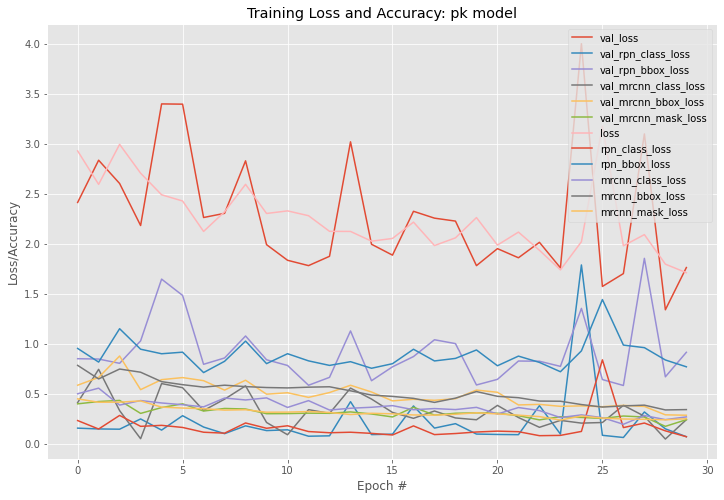

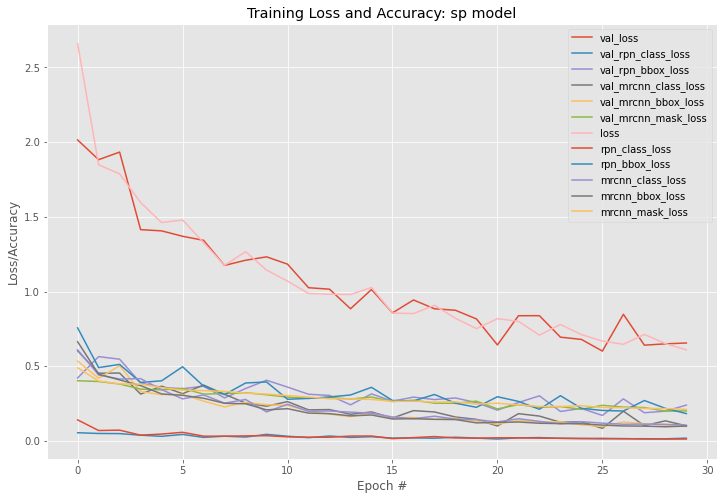

In [6]:
for key in ['c', 'uk', 'us', 'pk', 'sp']:
    path = 'D:\FAST\sem 2\Deep Learning\Assignments\A2\kaggle1\history_'+key+'.csv'
    hist_df = pd.read_csv(path)
    hist_df
    # plot the training loss and accuracy
    plt.rcParams["figure.figsize"] = (12,8)
    N = numpy.arange(0, len(hist_df))
    plt.style.use("ggplot")
    plt.figure()
    for i in hist_df.columns[1:]:
        plt.plot(N, hist_df[i], label=i)

    plt.title("Training Loss and Accuracy: "+key+" model")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend()

In [ ]:
import pandas as pd
import time
import numpy
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

hist_df = pd.DataFrame(datasets['pk']['history']) 
# or save to csv: 
hist_csv_file = 'history_'+'pk'+'.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

t = str(time.time())
model_path = 'mask_rcnn_'  + '.' + t + 'pk.h5'
datasets['pk']['model'].keras_model.save_weights(model_path)



In [ ]:
import numpy
import matplotlib.pyplot as plt
# plot the training loss and accuracy
plt.rcParams["figure.figsize"] = (12,8)
N = numpy.arange(0, 30)
plt.style.use("ggplot")
plt.figure()
for i in hist_df.columns:
    plt.plot(N, hist_df[i], label=i)

plt.title("Training Loss and Accuracy (Masked RCNN)")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

In [ ]:
from IPython.display import FileLink
FileLink(model_path)

In [ ]:
print("Loading Mask R-CNN model...")
datasets['pk']['model'] = modellib.MaskRCNN(mode="inference", config=config, model_dir='./')
#load the weights for COCO
datasets['pk']['model'].load_weights('mask_rcnn_.1623146807.8656645pk.h5', by_name=True)

In [ ]:
for i in range(71):
    image_id = i
    image, image_meta, gt_class_id, gt_bbox, gt_mask =    modellib.load_image_gt(datasets['pk']['test_set'], config, image_id, use_mini_mask=False)
    info = datasets['pk']['test_set'].image_info[image_id]
    print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                           datasets['pk']['test_set'].image_reference(image_id)))
    # Run object detection
    results = datasets['pk']['model'].detect([image], verbose=0)
    # Display results
    #print('results', results)
    r = results[0]
    visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                                datasets['pk']['test_set'].class_names, r['scores'], 
                                title="Predictions")

In [ ]:
for key in ['sp']:
    print("Loading Mask R-CNN model...")
    datasets[key]['model'] = modellib.MaskRCNN(mode="training", config=config, model_dir='./')
    #load the weights for COCO
    datasets[key]['model'].load_weights('../../input/coco-weights-for-maskedrcnn-matterport/mask_rcnn_coco.h5', 
                       by_name=True, 
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])
    datasets[key]['model'].train(datasets[key]['train_set'], datasets[key]['test_set'], learning_rate=2*config.LEARNING_RATE, epochs=30, layers='heads')
    datasets[key]['history'] = datasets[key]['model'].keras_model.history.history

    hist_df = pd.DataFrame(datasets[key]['history']) 
    # or save to csv: 
    hist_csv_file = 'history_'+key+'.csv'
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)

    t = str(time.time())
    model_path = 'mask_rcnn_'  + '.' + t + key +'.h5'
    datasets[key]['model'].keras_model.save_weights(model_path)

    # plot the training loss and accuracy
    plt.rcParams["figure.figsize"] = (12,8)
    N = numpy.arange(0, 30)
    plt.style.use("ggplot")
    plt.figure()
    for i in hist_df.columns:
        plt.plot(N, hist_df[i], label=i)

    plt.title("Training Loss and Accuracy (Masked RCNN)")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend()

In [ ]:
time.time()

In [ ]:
for key in ['us']:
    print("Loading Mask R-CNN model...")
    datasets[key]['model'] = modellib.MaskRCNN(mode="training", config=config, model_dir='./')
    #load the weights for COCO
    datasets[key]['model'].load_weights('../../input/coco-weights-for-maskedrcnn-matterport/mask_rcnn_coco.h5', 
                       by_name=True, 
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])
    datasets[key]['model'].train(datasets[key]['train_set'], datasets[key]['test_set'], learning_rate=2*config.LEARNING_RATE, epochs=30, layers='heads')
    datasets[key]['history'] = datasets[key]['model'].keras_model.history.history

    hist_df = pd.DataFrame(datasets[key]['history']) 
    # or save to csv: 
    hist_csv_file = 'history_'+key+'.csv'
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)

    t = str(time.time())
    model_path = 'mask_rcnn_'  + '.' + t + key +'.h5'
    datasets[key]['model'].keras_model.save_weights(model_path)

    # plot the training loss and accuracy
    plt.rcParams["figure.figsize"] = (12,8)
    N = numpy.arange(0, 30)
    plt.style.use("ggplot")
    plt.figure()
    for i in hist_df.columns:
        plt.plot(N, hist_df[i], label=i)

    plt.title("Training Loss and Accuracy (Masked RCNN)")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend()

In [ ]:
for key in ['us']:
    
    # plot the training loss and accuracy
    plt.rcParams["figure.figsize"] = (12,8)
    N = numpy.arange(0, 29)
    plt.style.use("ggplot")
    plt.figure()
    for i in hist_df.columns:
        plt.plot(N, hist_df[i], label=i)

    plt.title("Training Loss and Accuracy (Masked RCNN)")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend()

In [14]:
def merged_mask(masks):
    """
    merge mask into one and return merged mask
    """
    if len(masks.shape)==3:
        n= masks.shape[2]
    else:
        n = 0
    if n!=0:        
        merged_mask = np.zeros((masks.shape[0], masks.shape[1]))
        for i in range(n):
            merged_mask+=masks[...,i]
        merged_mask=np.asarray(merged_mask,dtype=np.uint8)   
        return merged_mask
    return masks[:,:]
    

def c_iou(predict_mask, gt_mask):
    """
    Computes Intersection over Union score for two binary masks.
    :param predict_mask: numpy array
    :param gt_mask: numpy array
    :type1 and type2 results are same
    :return iou score:
    """
    if predict_mask.shape[2]==0:
        return 0
    mask1 = merged_mask(predict_mask)
    mask2 = merged_mask(gt_mask)
    
#     #type 1
#     intersection = np.sum((mask1 + mask2) > 1)
#     union = np.sum((mask1 + mask2) > 0)
#     iou_score = intersection / float(union)
#     #print("Iou 1 : ",iou_score)
    
    #type2
    intersection = np.logical_and(mask1, mask2)#*
    union = np.logical_or(mask1, mask2)# +
    iou_score = np.sum(intersection) / np.sum(union)
    #print("Iou 2 : ",iou_score)
    return iou_score

# FINAL TESTING

In [18]:
#testing for IOUs per model
import glob


weight_path = glob.glob('../../input/id-models/mask_rcnn_c.*.h5')
#     files = [x[:-4] for x in list(listdir('../../input/idnation/'+key+'_labels'))]
res = {x:dict(zip(test_set_c.class_names[1:], np.empty((7,)))) for x in test_set_c.image_ids}

print("Loading Mask R-CNN model...")
model_c = modellib.MaskRCNN(mode="inference", config=config_c, model_dir='./')
  #load the weights for COCO
model_c.load_weights('../../input/id-models/mask_rcnn_c_.1623084794.8989007.h5', by_name=True)
    
for key in ['uk', 'us', 'sp', 'pk']:
    weight_path = glob.glob('../../input/id-models/mask_rcnn_.*'+key+'.h5')
#     files = [x[:-4] for x in list(listdir('../../input/idnation/'+key+'_labels'))]
    res = {x:dict(zip(datasets[key]['test_set'].class_names, np.empty((8,)))) for x in datasets[key]['test_set'].image_ids}

    print("Loading Mask R-CNN model...")
    datasets[key]['model'] = modellib.MaskRCNN(mode="inference", config=config, model_dir='./')
    #load the weights for COCO
    datasets[key]['model'].load_weights(weight_path[0], by_name=True)


#     print("Loading Mask R-CNN model...")
#     datasets[key]['model'] = modellib.MaskRCNN(mode="inference", config=config, model_dir='./')
#     #load the weights for COCO
#     datasets[key]['model'].load_weights(weight_path[0], by_name=True)

for i in range(len(test_set_c.image_ids)):
    key = 'c'
    image_id = i
    image_c, image_meta_c, gt_class_id_c, gt_bbox_c, gt_mask_c =    modellib.load_image_gt(test_set_c, config_c, image_id, use_mini_mask=False)
    info_c = test_set_c.image_info[image_id]

            # Run object detection
    results_c = model_c.detect([image_c], verbose=0)
            # Display results
            #print('results', results)
    r_c = results_c[0]

    for x in range(len(gt_class_id_c)):
        a_c = np.concatenate([np.where(r_c['class_ids']==gt_class_id_c[x])[0]])
                # print(a)
        if len(a_c)>0:
            pmasks_c = np.stack([r_c['masks'][:,:,i] for i in a_c], axis=2)
    #           print(gt_mask.shape)
            
            key = test_set_c.class_names[gt_class_id_c[x]]

            index = [x['id'] for x in datasets[key]['test_set'].image_info].index(info_c["id"])
            image, image_meta, gt_class_id, gt_bbox, gt_mask =    modellib.load_image_gt(datasets[key]['test_set'], config, index, use_mini_mask=False)
            info1 = datasets[key]['test_set'].image_info[index]
        #         print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], index, 
        #                                                    datasets[key]['test_set'].image_reference(index)))
            print('troubleshoot', info_c['id'], image_id, info1['id'], index)
            # Run object detection
            results = datasets[key]['model'].detect([image], verbose=0)
            # Display results
            #print('results', results)
            r = results[0]

            for x in range(len(gt_class_id)):
                a = np.concatenate([np.where(r['class_ids']==gt_class_id[x])[0]])
                # print(a)
                if len(a)>0:
                    pmasks = np.stack([r['masks'][:,:,i] for i in a], axis=2)
        #           print(gt_mask.shape)
                    iou = c_iou(pmasks, gt_mask[:,:,x])
            #                 print('IOU ', info['id'], datasets[key]['test_set'].class_names[gt_class_id[x]], iou)
                    res[test_set_c.image_ids[i]][datasets[key]['test_set'].class_names[gt_class_id[x]]]= iou
                

df = pd.DataFrame(res).T
df.to_csv("IOU_table_Final.csv")
print(df.head())

                           
    

Loading Mask R-CNN model...
Loading Mask R-CNN model...
Loading Mask R-CNN model...
Loading Mask R-CNN model...
Loading Mask R-CNN model...
troubleshoot apk00166232 0 apk00166232 21
troubleshoot apkf1f01dc692ad51acff2bef7c31c0cace232 1 apkf1f01dc692ad51acff2bef7c31c0cace232 145
troubleshoot apk00162332 3 apk00162332 349
troubleshoot usadownload (1)26 4 usadownload (1)26 119
troubleshoot apk71c9d219fc2179a7e7d6afbf20ddac1f232 8 apk71c9d219fc2179a7e7d6afbf20ddac1f232 174
troubleshoot usz-2124 10 usz-2124 264
troubleshoot apk00169332 11 apk00169332 16
troubleshoot us48832632553_2f7a6aef66_o818 13 us48832632553_2f7a6aef66_o818 289
troubleshoot usdownload912 14 usdownload912 93
troubleshoot spimages (2)15 15 spimages (2)15 9
troubleshoot spfake-Singapore-id-card-300x200515 16 spfake-Singapore-id-card-300x200515 125
troubleshoot apkf1f01dc692ad51acff2bef7c31c0cace432 17 apkf1f01dc692ad51acff2bef7c31c0cace432 163
troubleshoot apkEVqnFCPXgAA3S3S032 18 apkEVqnFCPXgAA3S3S032 219
troubleshoot apk

KeyError: 352

In [20]:

df = pd.DataFrame(res).T
df.to_csv("IOU_table_Final.csv")
print(df.head())


              BG          Fname          Lname       DOB    gender  \
0  6.918997e-310   7.581106e-01   7.615039e-01  0.792723  0.000000   
1  6.918997e-310   5.631374e-01   4.824659e-01  0.000000  0.803020   
2  6.918997e-310  4.670045e-310  2.121996e-314  0.000000  0.000000   
3  6.918997e-310   3.952333e-01   4.588209e-01  0.441093  0.683278   
4  6.918997e-310   7.319803e-01   8.458007e-01  0.748137  0.454273   

        IDnumber    nationality  
0   5.114990e-01   8.751703e-01  
1  4.670045e-310   7.257167e-01  
2  4.670045e-310  4.670045e-310  
3  4.670045e-310   6.347910e-01  
4   6.124898e-01   6.523112e-01  


In [ ]:
for key in ['sp', 'us', 'uk', 'pk']:
    print(key)
    print(pd.read_csv("IOU_table_"+key+".csv").describe())
    print(pd.read_csv("IOU_table_"+key+".csv").head())

In [ ]:
for key in ['sp']:
    print("Loading Mask R-CNN model...")
    datasets[key]['model'] = modellib.MaskRCNN(mode="training", config=config, model_dir='./')
    #load the weights for COCO
    datasets[key]['model'].load_weights('../../input/coco-weights-for-maskedrcnn-matterport/mask_rcnn_coco.h5', 
                       by_name=True, 
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])
    datasets[key]['model'].train(datasets[key]['train_set'], datasets[key]['test_set'], learning_rate=2*config.LEARNING_RATE, epochs=30, layers='heads')
    datasets[key]['history'] = datasets[key]['model'].keras_model.history.history

    hist_df = pd.DataFrame(datasets[key]['history']) 
    # or save to csv: 
    hist_csv_file = 'history_'+key+'.csv'
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)

    t = str(time.time())
    model_path = 'mask_rcnn_'  + '.' + t + key +'.h5'
    datasets[key]['model'].keras_model.save_weights(model_path)

    # plot the training loss and accuracy
    plt.rcParams["figure.figsize"] = (12,8)
    N = numpy.arange(0, 30)
    plt.style.use("ggplot")
    plt.figure()
    for i in hist_df.columns:
        plt.plot(N, hist_df[i], label=i)

    plt.title("Training Loss and Accuracy (Masked RCNN)")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend()
    
    print("Loading Mask R-CNN model...")
    datasets[key]['model'] = modellib.MaskRCNN(mode="inference", config=config, model_dir='./')
    #load the weights for COCO
    datasets[key]['model'].load_weights(model_path, by_name=True)
    
    for i in range(len(datasets[key]['test_set'].image_ids)):
        image_id = i
        image, image_meta, gt_class_id, gt_bbox, gt_mask =    modellib.load_image_gt(datasets[key]['test_set'], config, image_id, use_mini_mask=False)
        info = datasets[key]['test_set'].image_info[image_id]
        print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                               datasets[key]['test_set'].image_reference(image_id)))
        # Run object detection
        results = datasets[key]['model'].detect([image], verbose=0)
        # Display results
        #print('results', results)
        r = results[0]
        visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                                datasets[key]['test_set'].class_names, r['scores'], 
                                title="Predictions")

In [ ]:
import pandas as pd
import time

hist_df_pk = pd.DataFrame(history_pk) 
# or save to csv: 
hist_csv_file = 'history_c.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

t = str(time.time())
model_path_c = 'mask_rcnn_c_'  + '.' + t + '.h5'
model_c.keras_model.save_weights(model_path)
from IPython.display import FileLink
FileLink('mask_rcnn_c_'  + '.' + t + '.h5')

In [ ]:
import time
#t = str(time.time())
model_path = 'mask_rcnn_'  + '.' + t + '.h5'
model.keras_model.save_weights(model_path)

In [ ]:
from IPython.display import FileLink
FileLink('mask_rcnn_.1623003606.5874422.h5')

In [ ]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
#Loading the model in the inference mode
model = modellib.MaskRCNN(mode="inference", config=config, model_dir='./')
# loading the trained weights o the custom dataset
model.load_weights('mask_rcnn_.1623003606.5874422.h5', by_name=True)
img = load_img("../../input/id-dataset/images/0apk00163.jpg")
img = img_to_array(img)
# detecting objects in the image
result= model.detect([img])

In [ ]:
image_id = 26
image, image_meta, gt_class_id, gt_bbox, gt_mask =    modellib.load_image_gt(test_set, config, image_id, use_mini_mask=False)
info = test_set.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       test_set.image_reference(image_id)))
# Run object detection
results = model.detect([image], verbose=0)
# Display results
#print('results', results)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            test_set.class_names, r['scores'], 
                            title="Predictions")